This Python Notebook creates, validates, and tests the RL environment of a transport truck using Stable-Baselines3 library [1]. The model derives from the Lagrange's equations, and hence, is a compartment of a thermodynamical material network [2],[3]. The reward function is explained in [4]. The ordinary differential equations are solved numerically using the Euler's method [5].

### References
[1] Stable-Baselines3 (SB3) documentation: https://stable-baselines3.readthedocs.io/en/master/

[2] Zocco, F., Sopasakis, P., Smyth, B. and Haddad, W.M., 2023. Thermodynamical material networks for modeling, planning, and control of circular material flows. International Journal of Sustainable Engineering, 16(1), pp.1-14.

[3] Zocco, F. and Malvezzi, M., 2025. Circular economy design through system dynamics modeling. In International Workshop IFToMM for Sustainable Development Goals (pp. 530-538). Springer, Cham.

[4] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and
net zero. arXiv preprint arXiv:2505.21536.

[5] Euler's method for approximating the solution of ordinary differential equations: https://tutorial.math.lamar.edu/classes/de/eulersmethod.aspx


### Other Useful Reading
* Creating custom environment with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html  

* Practical advices for creating custom environments with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html#tips-and-tricks-when-creating-a-custom-environment

* To create this environment, I also followed the structure of the pendulum environment: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py

* Documentation of the pendulum environment: https://gymnasium.farama.org/environments/classic_control/pendulum/

* Formula for normalizing/de-normalizing the action space: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range  

* How to implement the normalization/de-normalization of the action space: https://github.com/hill-a/stable-baselines/issues/678

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Creation of the environment class with its constituent functions:

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium import spaces

"""
    This environment is the transportation truck model described in [1]. It is in the state-space form and consists of two first-order ordinary differential equations. The truck
    is approximated as a particle of mass 'm_total = m_truck + m_u' and subject to a force 'F', where 'm_u' is the mass of unsorted material sent to the incinerator. The incinerator
    is the destination and located at 'position_of_incinerator'.

    Action: F
    States/observations: position, speed

References:
    [1] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and
    net zero. arXiv preprint arXiv:2505.21536.
    [2] Zocco, F., Sopasakis, P., Smyth, B. and Haddad, W.M., 2023. Thermodynamical material networks for modeling, planning, and control of circular material flows. International Journal of Sustainable Engineering, 16(1), pp.1-14.
    [3] Zocco, F. and Malvezzi, M., 2025. Circular economy design through system dynamics modeling. In International Workshop IFToMM for Sustainable Development Goals (pp. 530-538). Springer, Cham.
"""

# Initial conditions:
position_ini = 0
speed_ini = 4


class transportTruck(gym.Env):

    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["console"]}



    def __init__(self, render_mode="console"):
        super(transportTruck, self).__init__()
        self.render_mode = render_mode

        # Integration step size:
        self.dt = 0.00005

        # Model parameters:
        self.m_truck = 3000 # kg
        self.m_u = 210 # kg
        self.m_total = self.m_truck + self.m_u
        self.F_min = -10**6
        self.F_max = 10**6 # N
        self.position_min = 0
        self.position_max = np.inf
        self.speed_min = 0
        self.speed_max = np.inf

        # Parameters for reward function:
        self.position_of_incinerator = 1000 # m

        # Define action and observation space with limits:
        min_values = np.array([self.position_min, self.speed_min], dtype=np.float32)
        max_values = np.array([self.position_max, self.speed_max], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(1,), dtype=np.float32
        ) # normalized between [-1, 1] as suggested in https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html

        self.observation_space = spaces.Box(low=min_values, high=max_values, dtype=np.float32)



    def step(self, F):  # Force 'F' is the action

      position, speed = self.state

      dt = self.dt
      m_total = self.m_total
      position_of_incinerator = self.position_of_incinerator
      F_min = self.F_min
      F_max = self.F_max

      # Clip and re-scale the action from [-1, 1] to [F_min, F_max] before the state-space equations:
      F = np.clip(F, -1, 1)[0] # convert 1-dim vector into scalar
      F = ((F-(-1))/(1-(-1)))*(F_max-F_min)+F_min # (general formula: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range)

      # State-space equations:
      position_dot = speed # first state equation
      speed_dot = F/m_total # second state equation

      # update the states using Euler's method (approximation):
      position = position + position_dot*dt
      speed = speed + speed_dot*dt


      # Reward, termination and truncation conditions:
      reward = - ((position_of_incinerator - position)**2 + 0.1*speed**2 + 0.001*F**2) # Similarly to the pendulum example: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py
      truncated = False # we do not limit the number of steps here, but in model.learn()
      terminated = False


      # Update the state:
      self.state = np.array([position, speed])
      obs = self.state

      # Optionally we can pass additional info:
      info = {"F (action)": F}

      return obs.astype(np.float32), float(reward), truncated, terminated, info


    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)
        self.state = np.array([position_ini, speed_ini], dtype=np.float32)

        return self.state, {}  # empty info dict



    def render(self):
        # Plot states vs. time:
        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_position, 'r-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (s)", fontsize=35)
        plt.ylabel(r"Position, $x$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_speed, 'b-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (s)", fontsize=35)
        plt.ylabel(r"Speed, $\dot{x}$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)


    def close(self):
        pass

### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that your environment follows the Gym interface. It also optionally checks that the environment is compatible with Stable-Baselines (and emits warning if necessary).

In [ ]:
from stable_baselines3.common.env_checker import check_env

env = transportTruck()
check_env(env, warn=True)

### Testing the environment

To test the environment, I compare its numerical solution with the one given by "integrate.odeint()" for the same initial conditions and for the same input F = 4000 N.

I found that the 2 solutions are stable and very similar for dt = 0.00005. The solution is plotted below.

[0. 4.]
Box(0.0, inf, (2,), float32)
Box(-1.0, 1.0, (1,), float32)


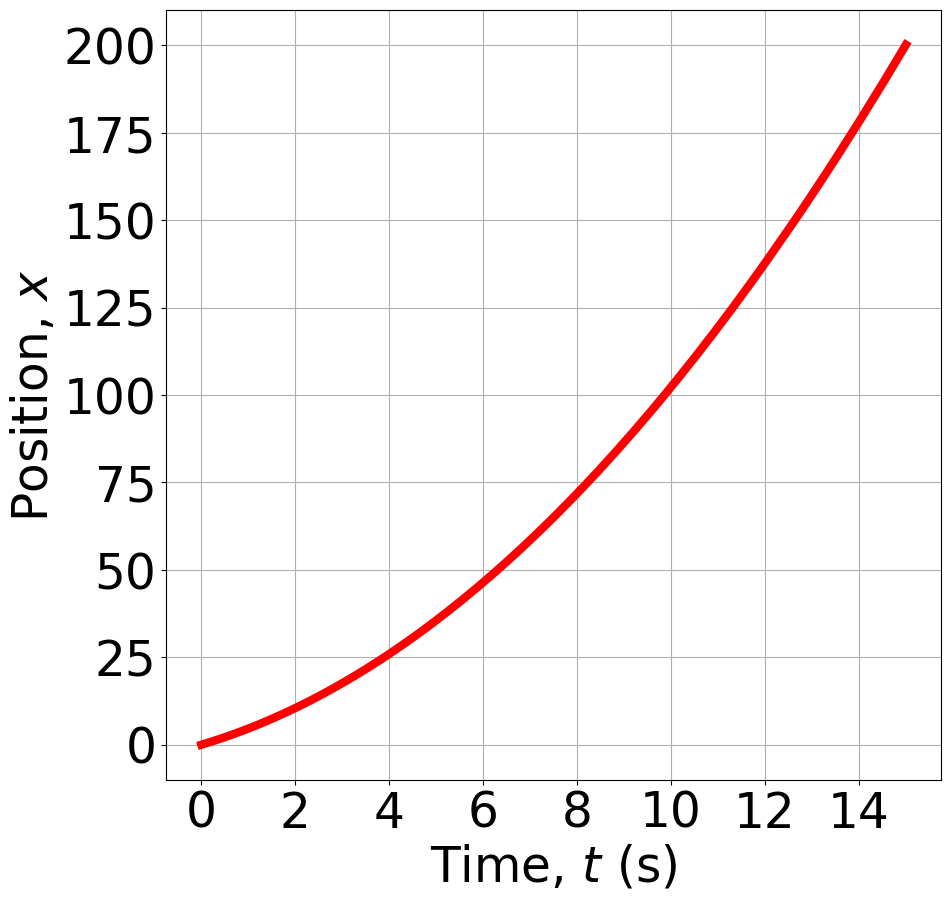

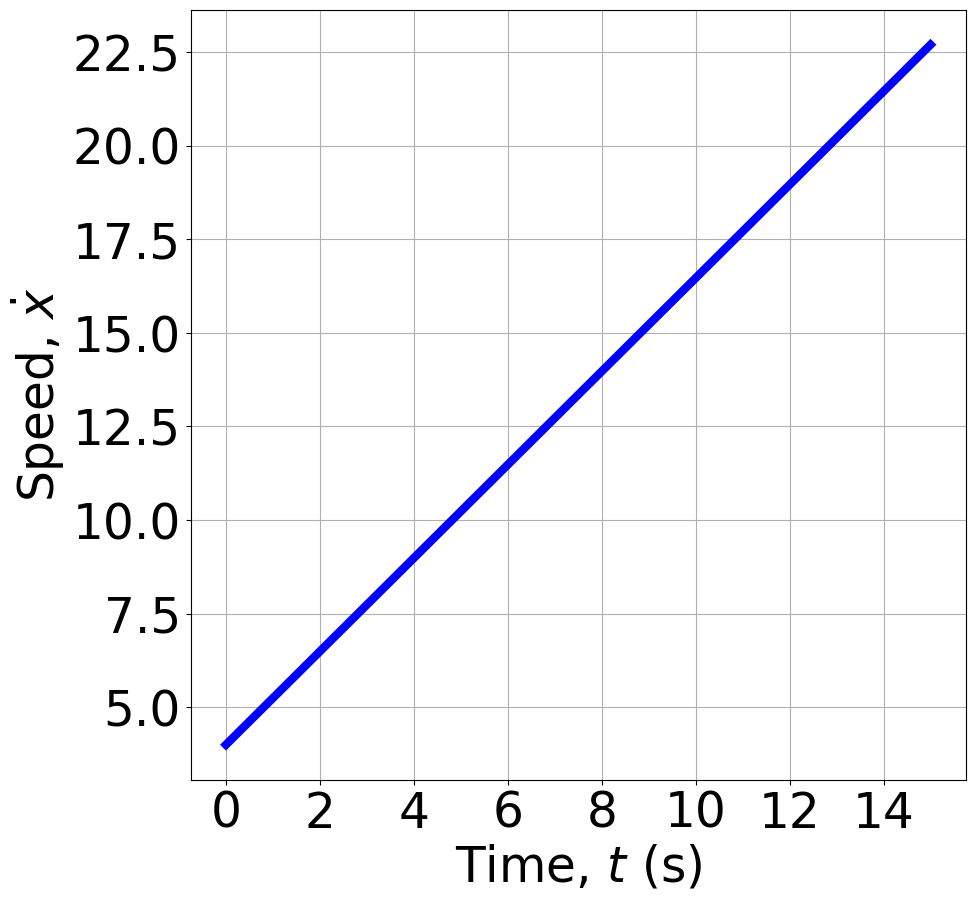

In [ ]:
env = transportTruck()

obs, _ = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)
#print(env.action_space.sample())

F = 4000
F = ((F-env.F_min)/(env.F_max-env.F_min))*(1-(-1))+(-1) # normalize to be in [-1,1] before use
F = [F] # between '[]' because step() expects this shape

n_steps = 300000

# For plotting:
vector_t = -np.ones(n_steps+1)
vector_position = -np.ones(n_steps+1)
vector_speed = -np.ones(n_steps+1)
vector_t[0] = 0
vector_position[0] = position_ini
vector_speed[0] = speed_ini

for step in range(n_steps):
    obs, reward, truncated, terminated, info = env.step(F)

    # For plotting:
    vector_t[step+1] = vector_t[step] + env.dt
    vector_position[step+1] = obs[0]
    vector_speed[step+1] = obs[1]

env.render()